In [208]:
%matplotlib inline
from matplotlib import pyplot
import geopandas
import numpy as np

from shapely.affinity import translate
from shapely.affinity import rotate
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import LineString

from shapely.wkt import dumps
from shapely.wkt import loads

from tile_units import TileUnit
from tile_map import Tiling

In [3]:
ak = geopandas.read_file("../data/imd-auckland-2018.gpkg")

# Cairo tiles
The one true tiling. Provides 4 directionally distinguishable elements... and also can be read two different ways (intersecting hexagons runninng in two orthogonal directions).

In [4]:
d = 500
tile_unit = TileUnit(spacing = d, crs = 2193)

<AxesSubplot:>

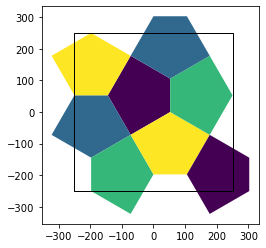

In [5]:
x = d / 2 * (np.sqrt(3) - 1) / 2 / np.sqrt(3)

poly1 = Polygon([
    (-d/2 + x, 0), (-d/4, -d/4), (0, -x), (0, x), (-d/4, d/4)
])
poly1 = translate(poly1, x, x)                                 # a
poly2 = rotate(poly1, 90, origin = poly1.exterior.coords[1])   # b
poly3 = rotate(poly1, 180, origin = poly1.exterior.coords[1])  # c
poly4 = rotate(poly1, 270, origin = poly1.exterior.coords[1])  # d
poly5 = rotate(poly4, 90, origin = poly4.exterior.coords[4])   # a 
poly6 = rotate(poly4, 270, origin = poly4.exterior.coords[4])  # c
poly7 = rotate(poly6, 270, origin = poly6.exterior.coords[1])  # b
poly8 = rotate(poly7, 180, origin = poly7.exterior.coords[4])  # d

tile_unit.elements = geopandas.GeoDataFrame(
    data = {"element_id": list("abcdacbd")}, crs = ak.crs,
    geometry = geopandas.GeoSeries(
        [poly1, poly2, poly3, poly4, poly5, poly6, poly7, poly8]))

ax = tile_unit.elements.plot(column = "element_id", cmap = "viridis")
tile_unit.tile.plot(ax = ax, edgecolor = "k", facecolor = "#00000000")

In [6]:
tiling = Tiling(tile_unit, ak, id_var = "DZ2018")
t30 = tiling.get_tiled_map(prioritise_tiles = True)

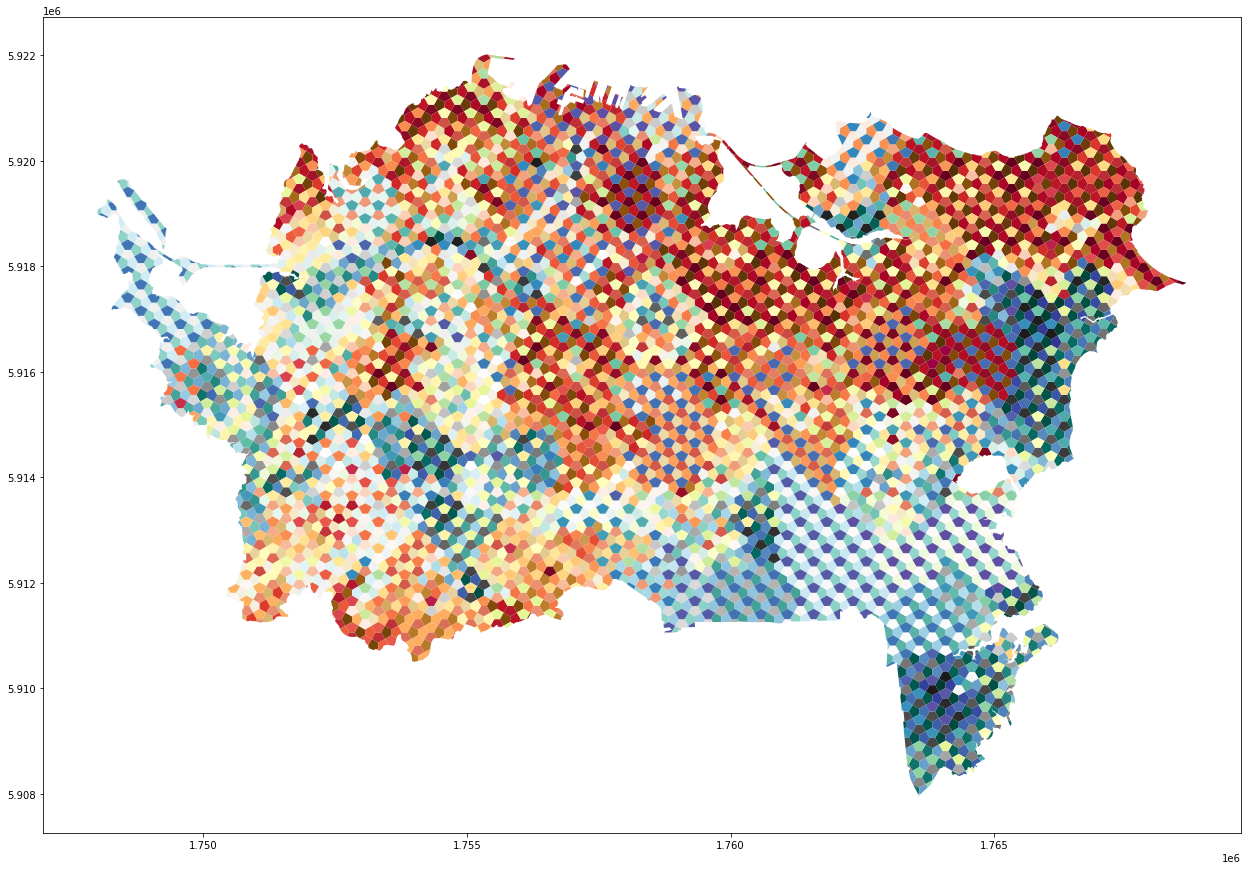

In [7]:
fig = pyplot.figure(figsize = (24, 15))
ax = fig.add_subplot(111)

strands = set(t30.element_id)
cols = [x for x in t30.columns if "Rank" in x]
cmaps = ("BrBG", "RdGy", "RdYlBu", "Spectral",
         "PiYG", "PRGn", "PuOr", "viridis")

for strand, col, cmap in zip(strands, cols, cmaps):
    t30[t30.element_id == strand].plot(ax = ax, column = col, cmap = cmap)

## Making the dual (an experiment)
Make a tiling of the tiling (which the Tiling constructor will 'grow'). Can figure out how to make this more controlled later.

In [219]:
def gridify(gs, precision = 6):
    return geopandas.GeoSeries([
        loads(dumps(p, rounding_precision = precision))
        for p in list(gs)])

In [220]:
dual_tiling_base = geopandas.GeoDataFrame(
    data = {"id": [1]}, crs = ak.crs,
    geometry = tile_unit.tile.geometry.buffer(
        500, cap_style = 3, join_style = 2)
)
dual_tiling_base.geometry

0    POLYGON ((750.000 -750.000, -750.000 -750.000,...
Name: geometry, dtype: geometry

<AxesSubplot:>

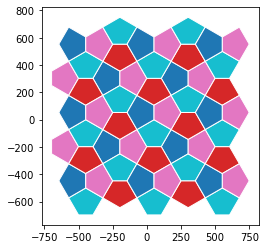

In [426]:

dual_tiling = Tiling(tile_unit, dual_tiling_base, id_var = "id")
# dual_tiling = dual_tiling.get_tiled_map(prioritise_tiles = True)
dual_tiling = dual_tiling.tiles
tiles_to_keep = []
ids = []
for p, id in zip(dual_tiling.geometry, dual_tiling.element_id):
    if p.within(dual_tiling_base.geometry[0]):
        tiles_to_keep.append(p)
        ids.append(id)
dual_tiling = geopandas.GeoDataFrame(
    data = {"element_id": ids}, crs = ak.crs,
    geometry = geopandas.GeoSeries(tiles_to_keep)
)
dual_tiling.plot(edgecolor = "w", column = "element_id")

61

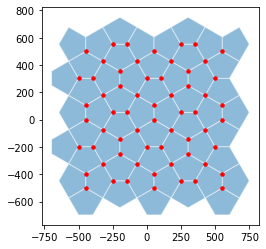

In [636]:
interior_pts = set()
uu = dual_tiling.geometry.unary_union

for p in dual_tiling.geometry:
    for pt in p.exterior.coords:
        if uu.contains(Point(pt)):
            interior_pts.add(pt)

interior_pts = geopandas.GeoSeries([Point(p) for p in interior_pts])
ax = dual_tiling.geometry.plot(alpha = 0.5, edgecolor = "w")
interior_pts.plot(ax = ax, markersize = 12, color = "r")
len(interior_pts)

<AxesSubplot:>

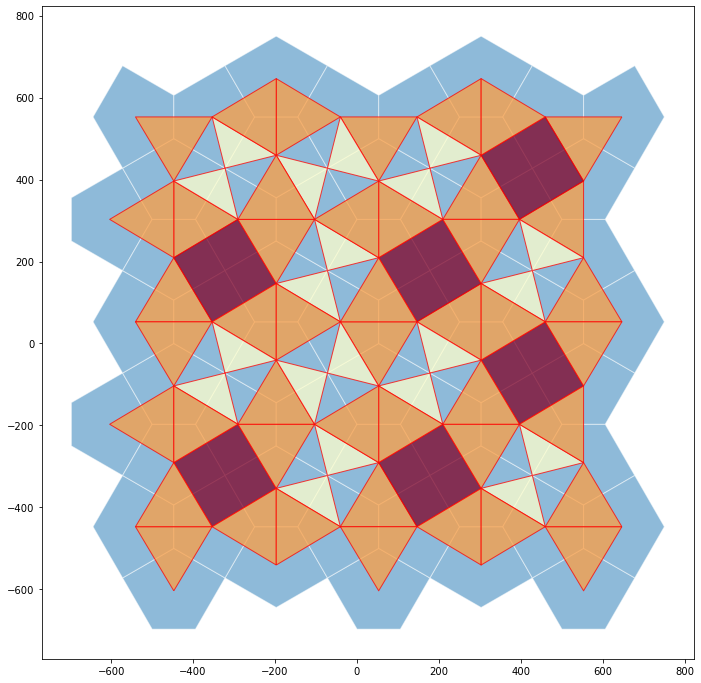

In [706]:
def untangle(pts):
    loop = pts + pts[:2]
    new_pts = pts.copy()
    n = len(pts)
    # swaps = [i for i in range(n)
    #          if not Polygon(loop[i:i+3]).exterior.is_ccw]
    # print(swaps)
    # if len(swaps) > 0:
    #     new_pts[swaps[0]] = loop[swaps[0] + 1]
    #     new_pts[swaps[0] + 1] = loop[swaps[0]]
    return new_pts


cycles = []
for pt in interior_pts:
    cycles.append(
        set([i for i, p in enumerate(dual_tiling.geometry) if
             pt.buffer(10).intersects(p)]))

faces = []
sides = []
for cycle in cycles:
    coords = []
    for i in cycle:
        centroid = dual_tiling.geometry[i].centroid
        coords.append([centroid.x, centroid.y])
    # if Polygon(coords).area < 0.001 or not Polygon(coords).exterior.is_ccw:
    #     coords = untangle(coords)
    faces.append(Polygon(coords))
    sides.append(len(cycle))

faces_gdf = geopandas.GeoDataFrame(
    data = {"sides": sides, "area": [f.area for f in faces]}, crs = ak.crs,
    geometry = geopandas.GeoSeries(faces)
)
ax = dual_tiling.geometry.plot(alpha = 0.5, figsize = (12, 12), edgecolor = "w")
faces_gdf.plot(ax = ax, edgecolor = "r", column = "area", 
               alpha = 0.75, cmap = "YlOrRd")